<a href="https://colab.research.google.com/github/mpt777/CS474/blob/main/lab5_style_swap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving halfdome.jpg to halfdome (2).jpg

Upload Style Image


Saving pink.jpg to pink.jpg
Content Path: <_io.BytesIO object at 0x7fccb118c990>
Style Path: <_io.BytesIO object at 0x7fccb118c780>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


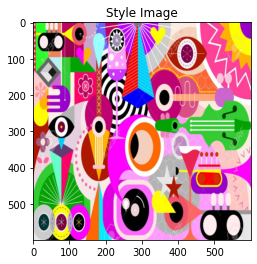

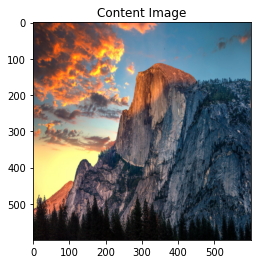

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = [10]
style_layers = [0,5,10,17]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
content_model = VGGIntermediate(content_layers).cuda()
style_model = VGGIntermediate(style_layers).cuda()

# Cache the outputs of the content and style layers for their respective images
content_output = content_model(content_image)
style_output = style_model(style_image[:,:3,:,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [7]:
def gram_matrix(input):
    b, f, h, w = input.size()  
    features = input.view(b * f, h * w)
    basis = torch.mm(features, features.t())
    gram = basis.div(b * f * h * w)

    return gram

  
class ContentLoss(nn.Module):
    def __init__(self, layer, img):
        super(ContentLoss, self).__init__()
        self.vgg = VGGIntermediate(layer).cuda()
        filters = self.vgg(img)
        self.filters_list = []

        for i in filters.keys():
            self.filters_list.append(filters[i].detach())

    def forward(self, input):
        filters = self.vgg(input)
        for i, j in enumerate(filters.keys()):
            loss = F.mse_loss(filters[j], self.filters_list[i])
        return loss
    
class StyleLoss(nn.Module):
    def __init__(self, layers, img):
        super(StyleLoss, self).__init__()
        self.vgg = VGGIntermediate(layers).cuda()
        filters = self.vgg(img)
        self.filters_list = []

        for i in filters.keys():
            self.filters_list.append(gram_matrix(filters[i].detach()))

    def forward(self, input):
        filters = self.vgg(input)
        loss = 0
        for i, j in enumerate(filters.keys()):
            loss += F.mse_loss( gram_matrix(filters[j]) , self.filters_list[i] ) / len(filters)
        return loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_object = ContentLoss(content_layers, content_image)

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_object = StyleLoss(style_layers, style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

**DONE:**
* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!



epoch:450, style_loss:85.08814239501953, content_loss:142.3778076171875: 100%|██████████| 10/10 [01:48<00:00, 10.86s/it]


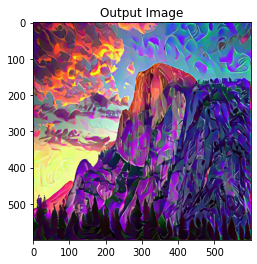

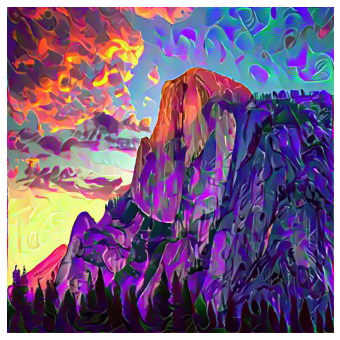

In [18]:
# Start with a copy of the content image
image = content_image.clone()

# Run the optimizer on the images to change the image
optimizer = optim.Adam([image.requires_grad_()], lr=0.01)

loss_list = []
alpha = 1
beta = 100000
epochs = 500
loop = tqdm(total=epochs//50, position=0, leave=True)

for epoch in range(epochs):
    optimizer.zero_grad()

#  using the loss of the style and content layers
#  to backpropagate errors
    content_loss = content_object(image) * alpha 
    style_loss = style_object(image) * beta
    loss = style_loss + content_loss

    loss.backward()
    optimizer.step()
    image.data.clamp_(0,1)

    if epoch % 50 == 0:
        loss_list.append(loss.item())
        loop.set_description(f'epoch:{epoch}, style_loss:{style_loss.item()}, content_loss:{content_loss.item()}')
        loop.update()

loop.close()

# Show the image
plt.figure()
display(image, title='Output Image')

#Save the image
image_plot = image[0].data.cpu().numpy().transpose(1,2,0)

plt.figure()
plt.imshow(image_plot)
figure = plt.gcf()
plt.axis('off')
figure.set_size_inches(6, 6)
plt.savefig('Output.jpg', bbox_inches='tight',transparent=True, pad_inches=0, dpi=100)

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

1) Layer Content that is a function of the vector p (Which represents the original image0 and vector x (which is the generated image), all done by the variable l, which is the layer.

This is equal to the sum of the MSE Loss between the activation filter and the image P. The sum iterates through i and j of our input activation filter and our ground truth image p. This is all done in our layer of interest l.

-

3) Gram Matrix is layer (l) that is equal to the sum of the feature map by layer sub i multiplied by the feature map by layer sub j. I and j are positions within the layer. So we loop over every position in the feature map with every other position in the feature map, and sum them up.

-

4) Al is the generated feature map by layer, and Gl is the gram matrix by layer. We sum up the MSE loss between Al and Gl, iterating through i and j, which means every every location in Al will have and MSE loss with every location in Gl. We then take this sum and multiply it to a/4(N dimensions of array squared)*(M dimensions of array squared). We will use the this E in our total loss of style.

-

5) Total loss style is a function of the vector a (the original image) and vector x (the generated image).

To find the total loss, we need to sum up all of the weights (w) per layer and multiple it to the derivative E (found above), with respect to the activation filter. We can find E by back propagating the loss.